<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Homework 8 - Policy Gradient

    
</center>


Student Name: _____Harshal Dafade (02125321)_____

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone. 
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [2]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


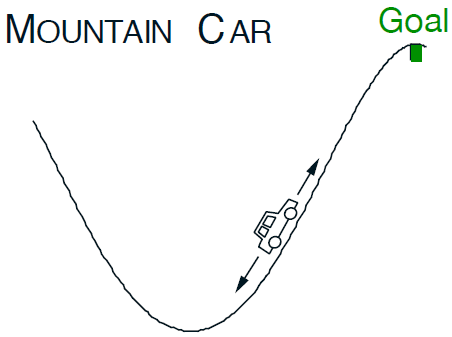


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.




**Note:** You have been given a simple implementation of the Mountain Car task. You can use your implementation of the function approximation from Homework 6, or implement a new one. 


## Part I (40 points)

Implement **ACTOR-CRITIC with Eligibility Traces** (p. 332).



In [3]:
import itertools

def get_fourier_basis(order, dimensions):
    c = list(itertools.product(range(order + 1), repeat=dimensions))
    c = np.array(c)
    return c

def bound_state(s):
    s_min = np.array([-1.2, -0.07]) 
    s_max = np.array([0.5, 0.07])   
    s_bounded = (s - s_min) / (s_max - s_min)
    return s_bounded

def compute_features(s, c):
    cs = np.dot(c, s)
    phi = np.cos(np.pi * cs)
    return phi

def softmax_policy(theta, phi_s):
    preferences = np.dot(theta, phi_s)
    max_pref = np.max(preferences) 
    exp_preferences = np.exp(preferences - max_pref)
    action_probs = exp_preferences / np.sum(exp_preferences)
    return action_probs

def actor_critic_with_eligibility_traces(env, alpha_w, alpha_theta, gamma, lambd, order, num_episodes):
    num_actions = env.action_space.n
    dimensions = env.observation_space.shape[0]
    c = get_fourier_basis(order, dimensions)
    num_features = c.shape[0]
    
    w = np.zeros(num_features)  
    theta = np.zeros((num_actions, num_features)) 
    
    total_rewards = []
    steps_per_episode = []
    
    for episode in range(num_episodes):
        observation, info = env.reset()
        s = observation
        phi_s = compute_features(bound_state(s), c)
        action_probs = softmax_policy(theta, phi_s)
        A = np.random.choice(num_actions, p=action_probs)
        
        z_w = np.zeros(num_features)
        z_theta = np.zeros((num_actions, num_features))
        
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            s_prime, reward, terminated, truncated, info = env.step(A)
            done = terminated or truncated
            R = reward
            phi_s_prime = compute_features(bound_state(s_prime), c)
            
            V_s = np.dot(w, phi_s)
            V_s_prime = np.dot(w, phi_s_prime) if not done else 0.0
            delta = R + gamma * V_s_prime - V_s
            z_w = gamma * lambd * z_w + phi_s
            w += alpha_w * delta * z_w
            
            action_probs_prime = softmax_policy(theta, phi_s)
            grad_ln_pi = -action_probs[:, None] * phi_s[None, :]
            grad_ln_pi[A] += phi_s
            z_theta = gamma * lambd * z_theta + grad_ln_pi
            theta += alpha_theta * delta * z_theta
            
            s = s_prime
            phi_s = phi_s_prime
            action_probs = softmax_policy(theta, phi_s)
            A = np.random.choice(num_actions, p=action_probs)
            
            total_reward += R
            steps += 1
        
        total_rewards.append(total_reward)
        steps_per_episode.append(steps)
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Steps: {steps}")
    
    return w, theta, total_rewards, steps_per_episode



## Part II (60 points)

(a) Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), Fourier Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$), and the $\lambda$-value. 


(b) Plot sum of reward-per-episode vs. number of episodes. This plot should be averaged over 50-100 runs.


(c) Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.

(d) Animate the last episode in a selected run. Does the approximated policy seem optimal? Why? What is the average optimal episode lenght?



Episode 10/500, Total Reward: -453.0, Steps: 453
Episode 20/500, Total Reward: -365.0, Steps: 365
Episode 30/500, Total Reward: -185.0, Steps: 185
Episode 40/500, Total Reward: -220.0, Steps: 220
Episode 50/500, Total Reward: -170.0, Steps: 170
Episode 60/500, Total Reward: -198.0, Steps: 198
Episode 70/500, Total Reward: -191.0, Steps: 191
Episode 80/500, Total Reward: -256.0, Steps: 256
Episode 90/500, Total Reward: -187.0, Steps: 187
Episode 100/500, Total Reward: -178.0, Steps: 178
Episode 110/500, Total Reward: -203.0, Steps: 203
Episode 120/500, Total Reward: -172.0, Steps: 172
Episode 130/500, Total Reward: -169.0, Steps: 169
Episode 140/500, Total Reward: -100.0, Steps: 100
Episode 150/500, Total Reward: -170.0, Steps: 170
Episode 160/500, Total Reward: -164.0, Steps: 164
Episode 170/500, Total Reward: -165.0, Steps: 165
Episode 180/500, Total Reward: -169.0, Steps: 169
Episode 190/500, Total Reward: -177.0, Steps: 177
Episode 200/500, Total Reward: -172.0, Steps: 172
Episode 2

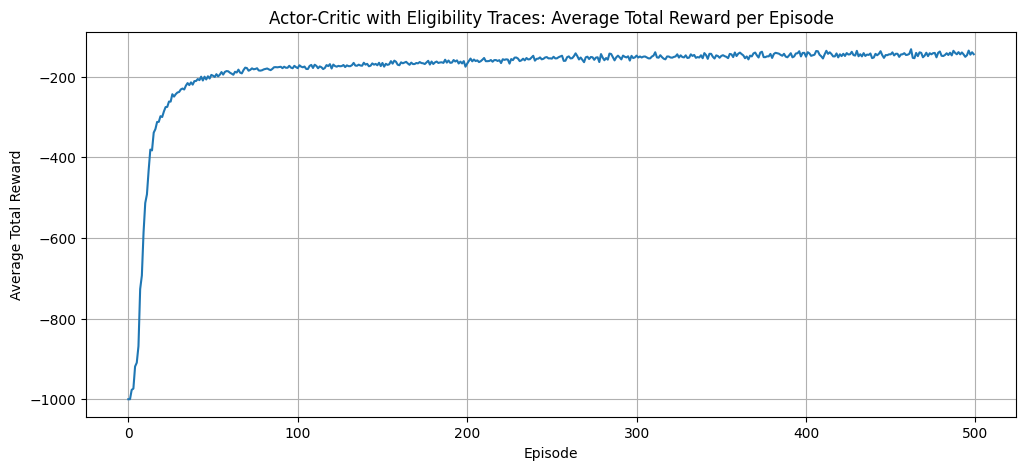

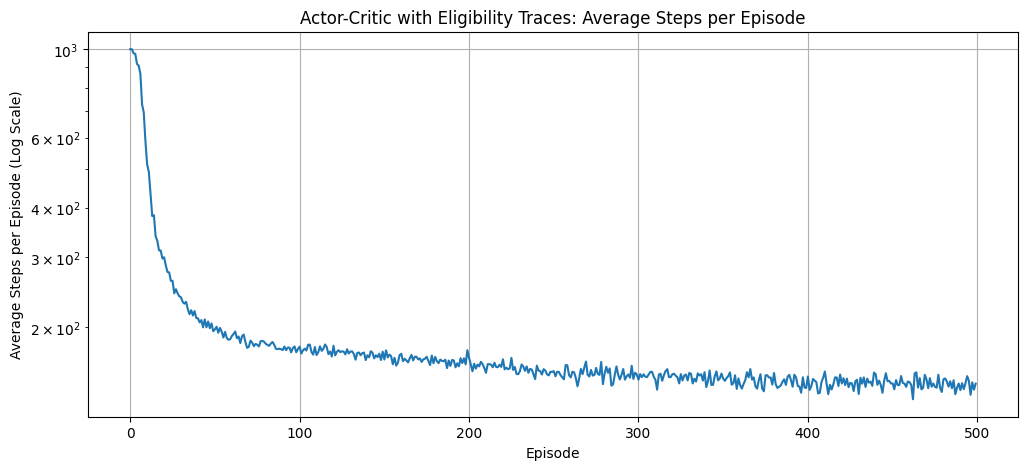

In [4]:

if __name__ == "__main__":
    env = gym.make('MountainCar-v0',max_episode_steps=1000)
    alpha_w = 0.001        
    alpha_theta = 0.0001   
    gamma = 1.0            
    lambd = 0.9          
    order = 4            
    num_episodes = 500     
    num_runs = 50       
    
    all_total_rewards = np.zeros((num_runs, num_episodes))
    all_steps_per_episode = np.zeros((num_runs, num_episodes))
    
    for run in range(num_runs):
        w, theta, total_rewards, steps_per_episode = actor_critic_with_eligibility_traces(
            env, alpha_w, alpha_theta, gamma, lambd, order, num_episodes)
        all_total_rewards[run, :] = total_rewards
        all_steps_per_episode[run, :] = steps_per_episode
        print(f"Completed run {run + 1}/{num_runs}")
    
    env.close()
    
    avg_total_rewards = np.mean(all_total_rewards, axis=0)
    avg_steps_per_episode = np.mean(all_steps_per_episode, axis=0)
    

    plt.figure(figsize=(12, 5))
    plt.plot(avg_total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Actor-Critic with Eligibility Traces: Average Total Reward per Episode')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.plot(avg_steps_per_episode)
    plt.yscale('log', base=10)
    plt.xlabel('Episode')
    plt.ylabel('Average Steps per Episode (Log Scale)')
    plt.title('Actor-Critic with Eligibility Traces: Average Steps per Episode')
    plt.grid(True)
    plt.show()

    env = gym.make('MountainCar-v0', render_mode='human')
    observation, info = env.reset()
    s = observation
    phi_s = compute_features(bound_state(s), get_fourier_basis(order, env.observation_space.shape[0]))
    action_probs = softmax_policy(theta, phi_s)
    A = np.argmax(action_probs)
    
    done = False
    while not done:
        s_prime, _, terminated, truncated, _ = env.step(A)
        done = terminated or truncated
        s = s_prime
        phi_s = compute_features(bound_state(s), get_fourier_basis(order, env.observation_space.shape[0]))
        action_probs = softmax_policy(theta, phi_s)
        A = np.argmax(action_probs)
        env.render()
    
    env.close()


Episode 10/500, Total Reward: -261.0, Steps: 261
Episode 20/500, Total Reward: -181.0, Steps: 181
Episode 30/500, Total Reward: -171.0, Steps: 171
Episode 40/500, Total Reward: -185.0, Steps: 185
Episode 50/500, Total Reward: -126.0, Steps: 126
Episode 60/500, Total Reward: -180.0, Steps: 180
Episode 70/500, Total Reward: -173.0, Steps: 173
Episode 80/500, Total Reward: -177.0, Steps: 177
Episode 90/500, Total Reward: -143.0, Steps: 143
Episode 100/500, Total Reward: -136.0, Steps: 136
Episode 110/500, Total Reward: -103.0, Steps: 103
Episode 120/500, Total Reward: -168.0, Steps: 168
Episode 130/500, Total Reward: -157.0, Steps: 157
Episode 140/500, Total Reward: -88.0, Steps: 88
Episode 150/500, Total Reward: -112.0, Steps: 112
Episode 160/500, Total Reward: -101.0, Steps: 101
Episode 170/500, Total Reward: -180.0, Steps: 180
Episode 180/500, Total Reward: -168.0, Steps: 168
Episode 190/500, Total Reward: -177.0, Steps: 177
Episode 200/500, Total Reward: -169.0, Steps: 169
Episode 210

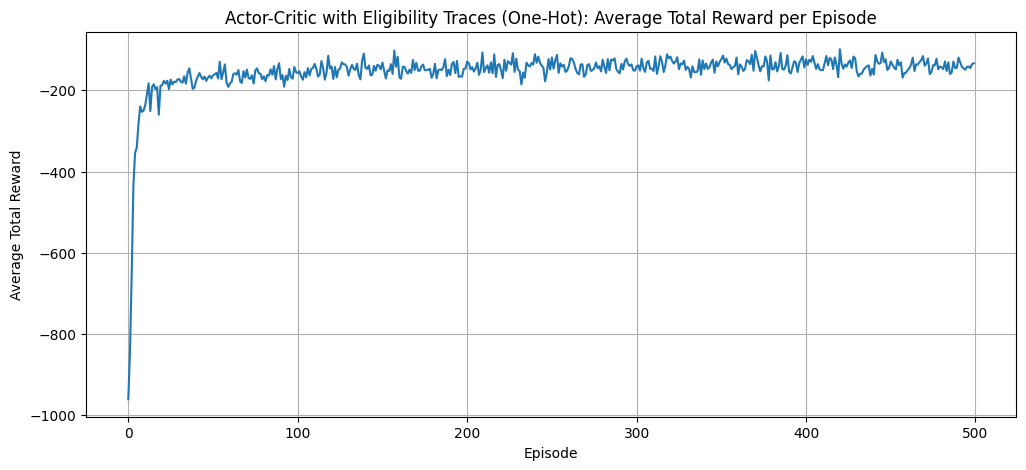

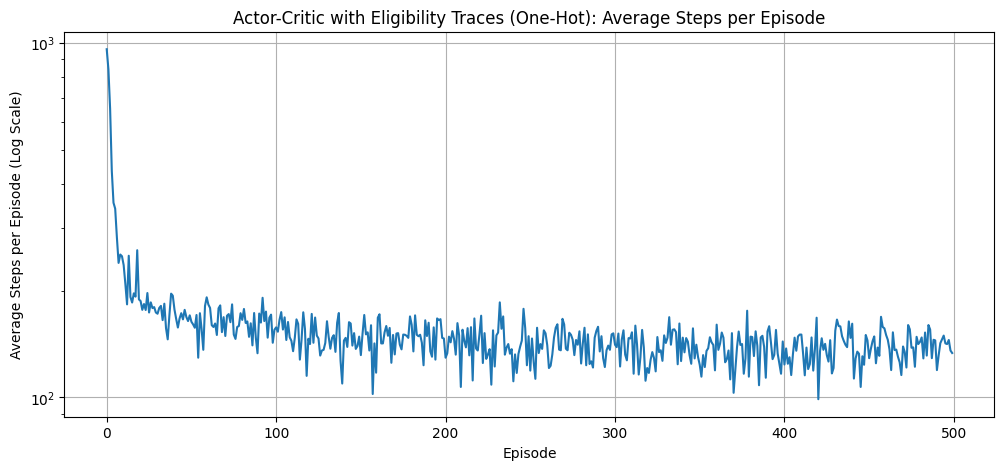

In [11]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import itertools

def get_fourier_basis(order, dimensions):
    c = list(itertools.product(range(order + 1), repeat=dimensions))
    c = np.array(c)
    return c

def bound_state(s):
    s_min = np.array([-1.2, -0.07]) 
    s_max = np.array([0.5, 0.07])   
    s_bounded = (s - s_min) / (s_max - s_min)
    return s_bounded

def compute_features(s, c):
    cs = np.dot(c, s)
    phi = np.cos(np.pi * cs)
    return phi

def softmax_policy(theta, phi_s):
    preferences = np.dot(theta, phi_s)
    max_pref = np.max(preferences) 
    exp_preferences = np.exp(preferences - max_pref)
    action_probs = exp_preferences / np.sum(exp_preferences)
    return action_probs

def actor_critic_with_eligibility_traces(env, alpha_w, alpha_theta, gamma, lambd, order, num_episodes):
    num_actions = env.action_space.n
    dimensions = env.observation_space.shape[0]
    c = get_fourier_basis(order, dimensions)
    num_features = c.shape[0]
    
    w = np.zeros(num_features)  
    theta = np.zeros((num_actions, num_features)) 
    
    total_rewards = []
    steps_per_episode = []
    
    for episode in range(num_episodes):
        observation, info = env.reset()
        s = observation
        phi_s = compute_features(bound_state(s), c)
        action_probs = softmax_policy(theta, phi_s)
        A = np.random.choice(num_actions, p=action_probs)
        
        z_w = np.zeros(num_features)
        z_theta = np.zeros((num_actions, num_features))
        
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            s_prime, reward, terminated, truncated, info = env.step(A)
            done = terminated or truncated
            R = reward
            phi_s_prime = compute_features(bound_state(s_prime), c)
            
            V_s = np.dot(w, phi_s)
            V_s_prime = np.dot(w, phi_s_prime) if not done else 0.0
            delta = R + gamma * V_s_prime - V_s
            z_w = gamma * lambd * z_w + phi_s
            w += alpha_w * delta * z_w
            
            # Actor update using one-hot encoding
            one_hot = np.zeros(num_actions)
            one_hot[A] = 1
            # grad_ln_pi = (one_hot - action_probs) * phi_s for each action
            grad_ln_pi = (one_hot - action_probs)[:, None] * phi_s[None, :]
            z_theta = gamma * lambd * z_theta + grad_ln_pi
            theta += alpha_theta * delta * z_theta
            
            s = s_prime
            phi_s = phi_s_prime
            action_probs = softmax_policy(theta, phi_s)
            A = np.random.choice(num_actions, p=action_probs)
            
            total_reward += R
            steps += 1
        
        total_rewards.append(total_reward)
        steps_per_episode.append(steps)
        
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Steps: {steps}")
    
    return w, theta, total_rewards, steps_per_episode



if __name__ == "__main__":
    env = gym.make('MountainCar-v0', max_episode_steps=1000)
    alpha_w = 0.005        
    alpha_theta = 0.0003   
    gamma = 1.0            
    lambd = 0.9          
    order = 4            
    num_episodes = 500     
    num_runs = 5       
    
    all_total_rewards = np.zeros((num_runs, num_episodes))
    all_steps_per_episode = np.zeros((num_runs, num_episodes))
    
    for run in range(num_runs):
        w, theta, total_rewards, steps_per_episode = actor_critic_with_eligibility_traces(
            env, alpha_w, alpha_theta, gamma, lambd, order, num_episodes)
        all_total_rewards[run, :] = total_rewards
        all_steps_per_episode[run, :] = steps_per_episode
        print(f"Completed run {run + 1}/{num_runs}")
    
    env.close()
    
    avg_total_rewards = np.mean(all_total_rewards, axis=0)
    avg_steps_per_episode = np.mean(all_steps_per_episode, axis=0)
    

    plt.figure(figsize=(12, 5))
    plt.plot(avg_total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Total Reward')
    plt.title('Actor-Critic with Eligibility Traces (One-Hot): Average Total Reward per Episode')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.plot(avg_steps_per_episode)
    plt.yscale('log', base=10)
    plt.xlabel('Episode')
    plt.ylabel('Average Steps per Episode (Log Scale)')
    plt.title('Actor-Critic with Eligibility Traces (One-Hot): Average Steps per Episode')
    plt.grid(True)
    plt.show()

    env = gym.make('MountainCar-v0', render_mode='human')
    observation, info = env.reset()
    s = observation
    phi_s = compute_features(bound_state(s), get_fourier_basis(order, env.observation_space.shape[0]))
    action_probs = softmax_policy(theta, phi_s)
    A = np.argmax(action_probs)
    
    done = False
    while not done:
        s_prime, _, terminated, truncated, _ = env.step(A)
        done = terminated or truncated
        s = s_prime
        phi_s = compute_features(bound_state(s), get_fourier_basis(order, env.observation_space.shape[0]))
        action_probs = softmax_policy(theta, phi_s)
        A = np.argmax(action_probs)
        env.render()
    
    env.close()
